<a href="https://colab.research.google.com/github/marcospgp/backpropagation-from-scratch/blob/master/backpropagation-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading MNIST dataset from Keras


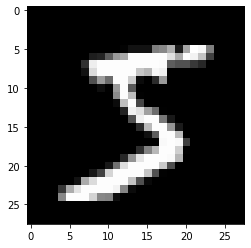

In [178]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

plt.imshow(x_train[0],cmap='gray');

# Utility functions

In [179]:
import numpy as np

def sigmoid(x):
  # Numerically stable sigmoid function based on
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  
  x = np.clip(x, -500, 500) # We get an overflow warning without this
  
  return np.where(
    x >= 0,
    1 / (1 + np.exp(-x)),
    np.exp(x) / (1 + np.exp(x))
  )

def dsigmoid(x): # Derivative of sigmoid
  return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
  # Numerically stable softmax based on (same source as sigmoid)
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  b = x.max()
  y = np.exp(x - b)
  return y / y.sum()

def cross_entropy_loss(y, yHat):
  return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, max):
  # x: integer to convert to one hot encoding
  # max: the size of the one hot encoded array
  result = np.zeros(10)
  result[x] = 1
  return result

# Initialize architecture, weights, and biases

Weight distribution per layer:


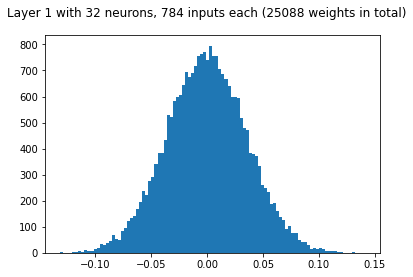

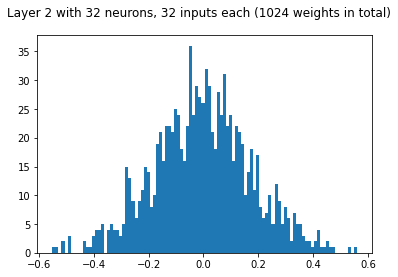

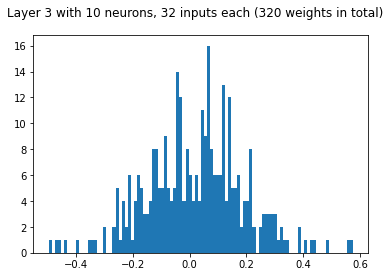

In [180]:
import math

# Initialize weights of each layer with a normal distribution of mean 0 and
# standard deviation 1/sqrt(n), where n is the number of inputs.
# This means the weighted input will be a random variable itself with mean
# 0 and standard deviation close to 1 (if biases are initialized as 0, standard
# deviation will be exactly 1)

from numpy.random import default_rng

rng = default_rng(80085)

# Neural network layer sizes: 784 -> 32 -> 32 -> 10

weights = [
  rng.normal(0, 1/math.sqrt(784), (32, 784)),
  rng.normal(0, 1/math.sqrt(32), (32, 32)),
  rng.normal(0, 1/math.sqrt(32), (10, 32))
]

biases = [np.zeros(32), np.zeros(32), np.zeros(10)]

# Plot histogram of layer weights to check probability distribution

print("Weight distribution per layer:")
for index, layer in enumerate(weights):
  plt.figure()
  plt.suptitle(
    "Layer " + str(index + 1) + " with " + str(layer.shape[0]) +
    " neurons, " + str(layer.shape[1]) + " inputs each (" + str(layer.size) +
    " weights in total)"
  )
  plt.hist(layer.flatten(), bins=100);


# Feed forward

Feed forward once before training to check accuracy

In [181]:
def feed_forward_sample(sample, y):
  """ Feeds a sample forward through the neural network.
    Parameters:
      sample: 1D numpy array. The input sample (an MNIST digit).
      label: An integer from 0 to 9.

    Returns: The cross entropy loss.
  """
  a = sample.flatten()

  for index, w in enumerate(weights):
    z = np.matmul(w, a) + biases[index]
    if index < len(weights) - 1:
      a = sigmoid(z)
    else:
      a = softmax(z)

  # Calculate loss
  one_hot_y = integer_to_one_hot(y, 10)
  loss = cross_entropy_loss(one_hot_y, a)

  # Convert activations to one hot encoded guess
  one_hot_guess = np.zeros_like(a)
  one_hot_guess[np.argmax(a)] = 1
  
  return loss, one_hot_guess


# Feedforward all training samples
def feed_forward_dataset(x, y):
  losses = np.empty(x.shape[0])
  one_hot_guesses = np.empty((x.shape[0], 10))

  for i in range(x.shape[0]):
    if i == 0 or ((i + 1) % 10000 == 0):
      print(i + 1, "/", x.shape[0], "(", format(((i + 1) / x.shape[0]) * 100, ".2f"), "%)")
    losses[i], one_hot_guesses[i] = feed_forward(x[i], y[i])

  print("\nAverage loss:", np.round(np.average(losses), decimals=2))

  y_one_hot = np.zeros((y.size, 10))
  y_one_hot[np.arange(y.size), y] = 1

  # Expected correct guesses 6 000/60 000, assuming perfect randomness
  correct_guesses = np.sum(y_one_hot * one_hot_guesses)
  correct_guess_percent = format((correct_guesses / y.shape[0]) * 100, ".2f")
  print("Accuracy (# of correct guesses):", correct_guesses, "/", y.shape[0], "(", correct_guess_percent, "%)")

def feed_forward_training_data():
  print("Feeding forward all training data...")
  feed_forward_dataset(x_train, y_train)
  print("")

def feed_forward_test_data():
  print("Feeding forward all test data...")
  feed_forward_dataset(x_test, y_test)
  print("")

feed_forward_test_data()

Feeding forward all test data...
1 / 10000 ( 0.01 %)
10000 / 10000 ( 100.00 %)

Average loss: 2.36
Accuracy (# of correct guesses): 994.0 / 10000 ( 9.94 %)



# Training

1.   Feedforward one sample, storing layer activations
2.   Calculate gradient
3.   Update weights & biases according to learning rate
4.   Repeat

More details about this implementation [here](https://www.mathcha.io/editor/vrmV3C1KFnvu2Dx3ewh7rgr54fBOvJL2TzoNWNe)

The maximum accuracy reached was ~85%, after training for a few epochs. The network then starts to overfit.




In [182]:
def train_one_sample(sample, y, learning_rate=0.003):
  a = sample.flatten()

  # We will store each layer's activations to calculate gradient
  activations = []

  # Feedforward
  for i, w in enumerate(weights): # Each w is a layer's 2D weight matrix
    z = np.matmul(w, a) + biases[i]
    if (i < len(weights) - 1):
      a = sigmoid(z)
    else:  
      a = softmax(z) # softmax on last layer
    activations.append(a)

  # Calculate loss
  one_hot_y = integer_to_one_hot(y, 10)
  loss = cross_entropy_loss(one_hot_y, a)

  # Convert last layer's activations to one hot encoded guess
  one_hot_guess = np.zeros_like(a)
  one_hot_guess[np.argmax(a)] = 1

  # Check whether guess was correct
  correct_guess = (np.sum(one_hot_y * one_hot_guess) == 1)

  weight_gradients = [None] * len(weights)
  bias_gradients = [None] * len(weights)
  activation_gradients = [None] * (len(weights) - 1)
  
  # Backpropagation
  for i in range(len(weights) - 1, -1, -1): # Traverse layers in reverse
    last_layer = i == len(weights) - 1
    second_to_last_layer = i == len(weights) - 2

    if last_layer:
      # Gather all needed variables, making vectors vertical
      y = one_hot_y[:, np.newaxis]
      a = activations[i][:, np.newaxis]
      a_prev = activations[i-1][:, np.newaxis]

      weight_gradients[i] = np.matmul((a - y), a_prev.T)
      bias_gradients[i] = a - y

    else:
      # Gather all needed variables, making vectors vertical
      w_next = weights[i+1]
      a_next = activations[i + 1][:, np.newaxis]
      y = one_hot_y[:, np.newaxis]
      a = activations[i][:, np.newaxis]
      if i > 0:
        a_prev = activations[i-1][:, np.newaxis]
      else:
        # Previous activation is the sample itself
        a_prev = sample.flatten()[:, np.newaxis]

      # Activation gradient
      if second_to_last_layer:
        dCda = np.matmul(w_next.T, (a_next - y))
        activation_gradients[i] = dCda
      else:
        dCda_next = activation_gradients[i+1]
        dCda = np.matmul(w_next.T, (dsigmoid(a_next) * dCda_next))
        activation_gradients[i] = dCda

      # Weights & biases gradients
      x = dsigmoid(a) * dCda
      weight_gradients[i] = np.matmul(x, a_prev.T)
      bias_gradients[i] = x

    # Update weights & biases based on gradient
    weights[i] -= weight_gradients[i] * learning_rate
    biases[i] -= bias_gradients[i].flatten() * learning_rate

def train_one_epoch(learning_rate=0.003):
  print("Training for one epoch over the training dataset...")
  for i in range(x_train.shape[0]):
    if i == 0 or ((i + 1) % 10000 == 0):
      completion_percent = format(((i + 1) / x_train.shape[0]) * 100, ".2f")
      print(i + 1, "/", x_train.shape[0], "(", completion_percent, "%)")
    train_one_sample(x_train[i], y_train[i], learning_rate)
  print("Finished training.\n")

# Train and check accuracy before & after each epoch

feed_forward_test_data()

def test_and_train():
  train_one_epoch()
  feed_forward_test_data()

for i in range(3): # Adjust number of epochs here
  test_and_train()

Feeding forward all test data...
1 / 10000 ( 0.01 %)
10000 / 10000 ( 100.00 %)

Average loss: 2.36
Accuracy (# of correct guesses): 994.0 / 10000 ( 9.94 %)

Training for one epoch over the training dataset...
1 / 60000 ( 0.00 %)
10000 / 60000 ( 16.67 %)
20000 / 60000 ( 33.33 %)
30000 / 60000 ( 50.00 %)
40000 / 60000 ( 66.67 %)
50000 / 60000 ( 83.33 %)
60000 / 60000 ( 100.00 %)
Finished training.

Feeding forward all test data...
1 / 10000 ( 0.01 %)
10000 / 10000 ( 100.00 %)

Average loss: 0.63
Accuracy (# of correct guesses): 8023.0 / 10000 ( 80.23 %)

Training for one epoch over the training dataset...
1 / 60000 ( 0.00 %)
10000 / 60000 ( 16.67 %)
20000 / 60000 ( 33.33 %)
30000 / 60000 ( 50.00 %)
40000 / 60000 ( 66.67 %)
50000 / 60000 ( 83.33 %)
60000 / 60000 ( 100.00 %)
Finished training.

Feeding forward all test data...
1 / 10000 ( 0.01 %)
10000 / 10000 ( 100.00 %)

Average loss: 0.51
Accuracy (# of correct guesses): 8481.0 / 10000 ( 84.81 %)

Training for one epoch over the trainin